# Домашнее задание 

В этом задании мы попрактикуемся в методах снижения размерности и кластеризации данных. 

Мы будем работать с набором данных Samsung Human Activity Recognition. Скачайте данные по ссылке https://archive.ics.uci.edu/ml/machine-learning-databases/00240/. Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3, также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков.

In [2]:
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [3]:
X_train = np.loadtxt("X_train.txt")
y_train = np.loadtxt("y_train.txt").astype(int)

X_test = np.loadtxt("X_test.txt")
y_test = np.loadtxt("y_test.txt").astype(int)

Для кластеризации нам не нужен вектор ответов. Объедините обучающую и тестовую выборки.

In [4]:

X = np.concatenate([X_test, X_train])
y = np.concatenate([y_test, y_train])

In [5]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

Эти метки соответствуют:

1 - ходьбе,
2 - подъему вверх по лестнице,
3 - спуску по лестнице,
4 - сидению,
5 - стоянию,
6 - лежанию

Отмасштабируйте выборку с помощью StandardScaler.

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(X)

[[ 0.25717778 -0.02328523 -0.01465376 ... -0.72000927  0.27680104
  -0.0579783 ]
 [ 0.28602671 -0.01316336 -0.11908252 ... -0.69809082  0.28134292
  -0.08389801]
 [ 0.27548482 -0.02605042 -0.11815167 ... -0.70277146  0.28008303
  -0.0793462 ]
 ...
 [ 0.27338737 -0.01701062 -0.04502183 ... -0.77913261  0.24914484
   0.04081119]
 [ 0.28965416 -0.01884304 -0.15828059 ... -0.78518142  0.24643223
   0.02533948]
 [ 0.35150347 -0.01242312 -0.20386717 ... -0.78326693  0.24680852
   0.03669484]]


Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state.

In [7]:
pca = PCA(n_components=2, random_state=42)
X_transformed = pca.fit_transform(X)

Визуализируйте данные в проекции на первые две главные компоненты.

Text(0, 0.5, 'y')

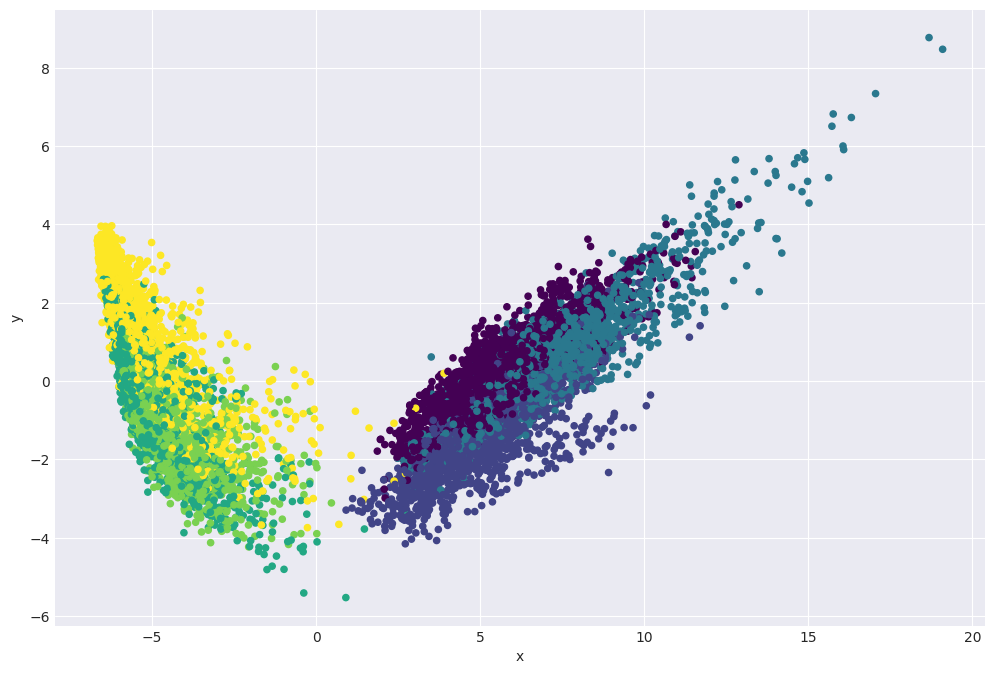

In [8]:
plt.figure(figsize=(12,8))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=y, s=20, cmap='viridis')
plt.xlabel('x')
plt.ylabel('y')

Сделайте кластеризацию данных методом KMeans, обучив модель на данных со сниженной за счет PCA размерностью. В данном случае нужно искать 6 кластеров (так как у нас 6 классов).

Параметры:

n_clusters = n_classes (число уникальных меток целевого класса)

n_init = 100

random_state = RANDOM_STATE (для воспроизводимости результата)

In [25]:
kmeans = KMeans(n_clusters=6, random_state=RANDOM_STATE, n_init=100)
kmeans.fit(X_transformed)
print(kmeans.labels_) 



[1 4 4 ... 3 3 3]


Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

Text(0, 0.5, 'y')

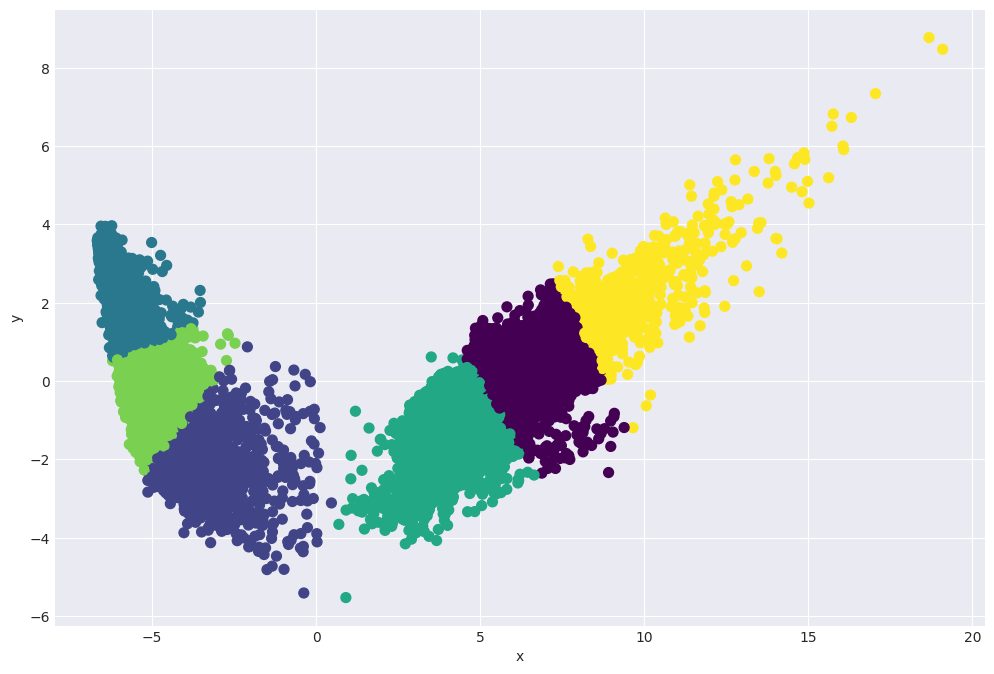

In [27]:
plt.figure(figsize=(12,8))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=kmeans.labels_, s=50, cmap='viridis')
plt.xlabel('x')
plt.ylabel('y')

Выведите на экран значения метрик качества кластеризации

In [28]:
from sklearn import metrics

labels = y

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, kmeans.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, kmeans.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, kmeans.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, kmeans.labels_))
print("Adjusted mutual info score: %.3f"
      % metrics.adjusted_mutual_info_score(labels, kmeans.labels_))

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, kmeans.labels_, sample_size=1000))

order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

Homogeneity: 0.451
Completeness: 0.467
V-measure: 0.459
Adjusted Rand-Index: 0.298
Adjusted mutual info score: 0.459
Silhouette Coefficient: 0.081


Теперь попробуем сделать кластеризацию с помощью AgglomerativeClustering (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

In [33]:
ag = AgglomerativeClustering(n_clusters=6, 
                             linkage='ward').fit(X_transformed)

print(ag.labels_) 

[1 1 0 ... 2 2 2]


Text(0, 0.5, 'y')

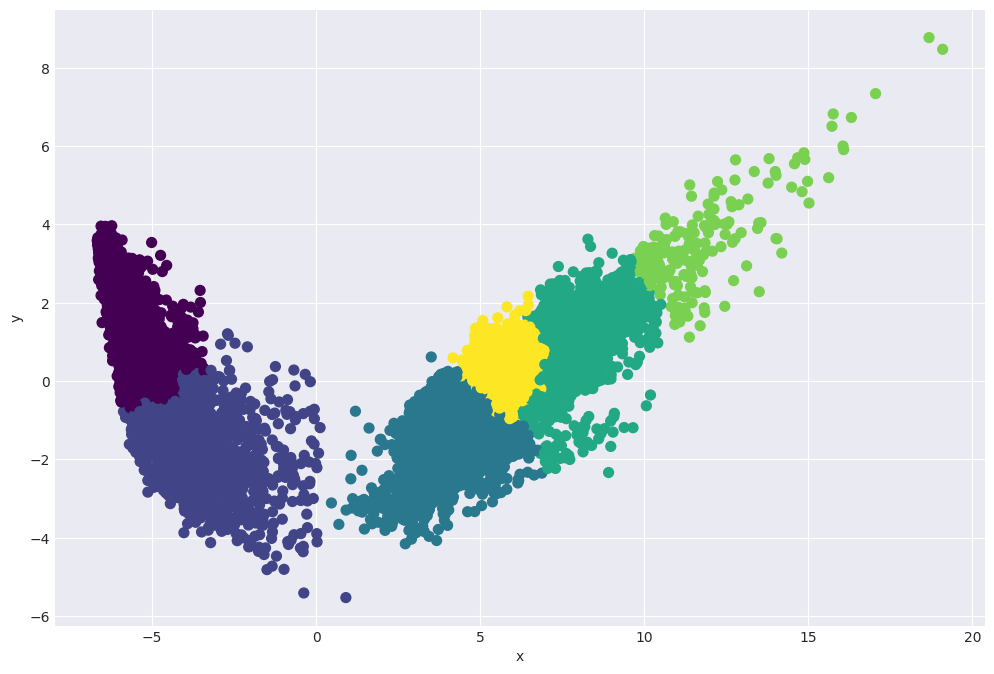

In [34]:
plt.figure(figsize=(12,8))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=ag.labels_, s=50, cmap='viridis')
plt.xlabel('x')
plt.ylabel('y')

Выведите метрики качества для полученного разбиения на кластеры. Сравните с kmeans. Запишите выводы!

In [35]:
labels = y

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, ag.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, ag.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, ag.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, ag.labels_))
print("Adjusted mutual info score: %.3f"
      % metrics.adjusted_mutual_info_score(labels, ag.labels_))

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, ag.labels_, sample_size=1000))

#в целом разница не очень большая, но с ac кластеризация получилась немного точнее


Homogeneity: 0.446
Completeness: 0.497
V-measure: 0.470
Adjusted Rand-Index: 0.313
Adjusted mutual info score: 0.470
Silhouette Coefficient: 0.095


Попробуйте применить другие методы кластеризации из sklearn. Также вычислите метрики качества и сделайте вывод о том, какой метод сработал лучше.

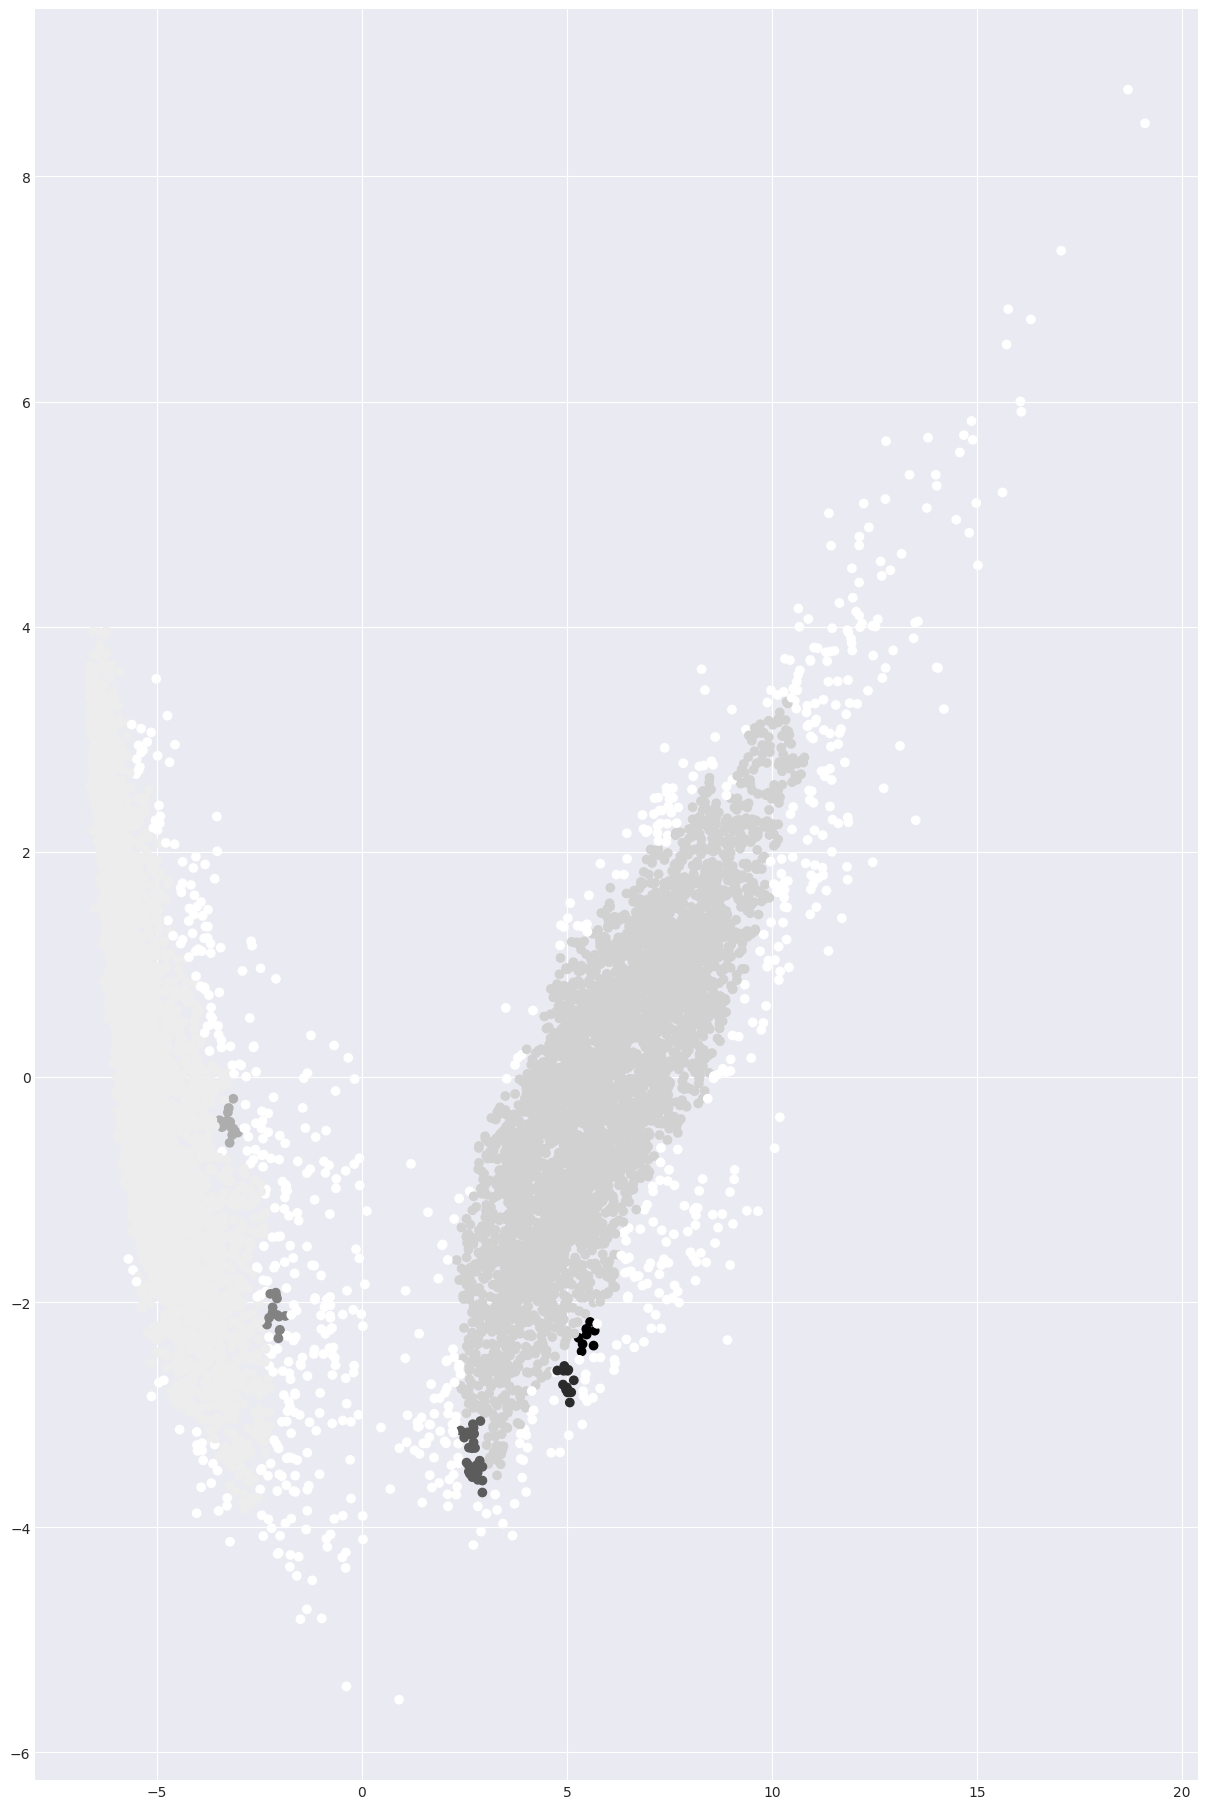

In [79]:
from sklearn.cluster import DBSCAN

plt.figure(figsize= (15,23))

dbscan = DBSCAN(eps=0.2, min_samples=10)
clusters = dbscan.fit_predict(X_transformed)
plt.scatter(X_transformed[:,0], X_transformed[:,1], c = clusters)

plt.show()

In [80]:
labels = y

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, dbscan.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, dbscan.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, dbscan.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, dbscan.labels_))
print("Adjusted mutual info score: %.3f"
      % metrics.adjusted_mutual_info_score(labels, dbscan.labels_))

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, dbscan.labels_, sample_size=1000))

Homogeneity: 0.362
Completeness: 0.678
V-measure: 0.472
Adjusted Rand-Index: 0.312
Adjusted mutual info score: 0.471
Silhouette Coefficient: 0.210


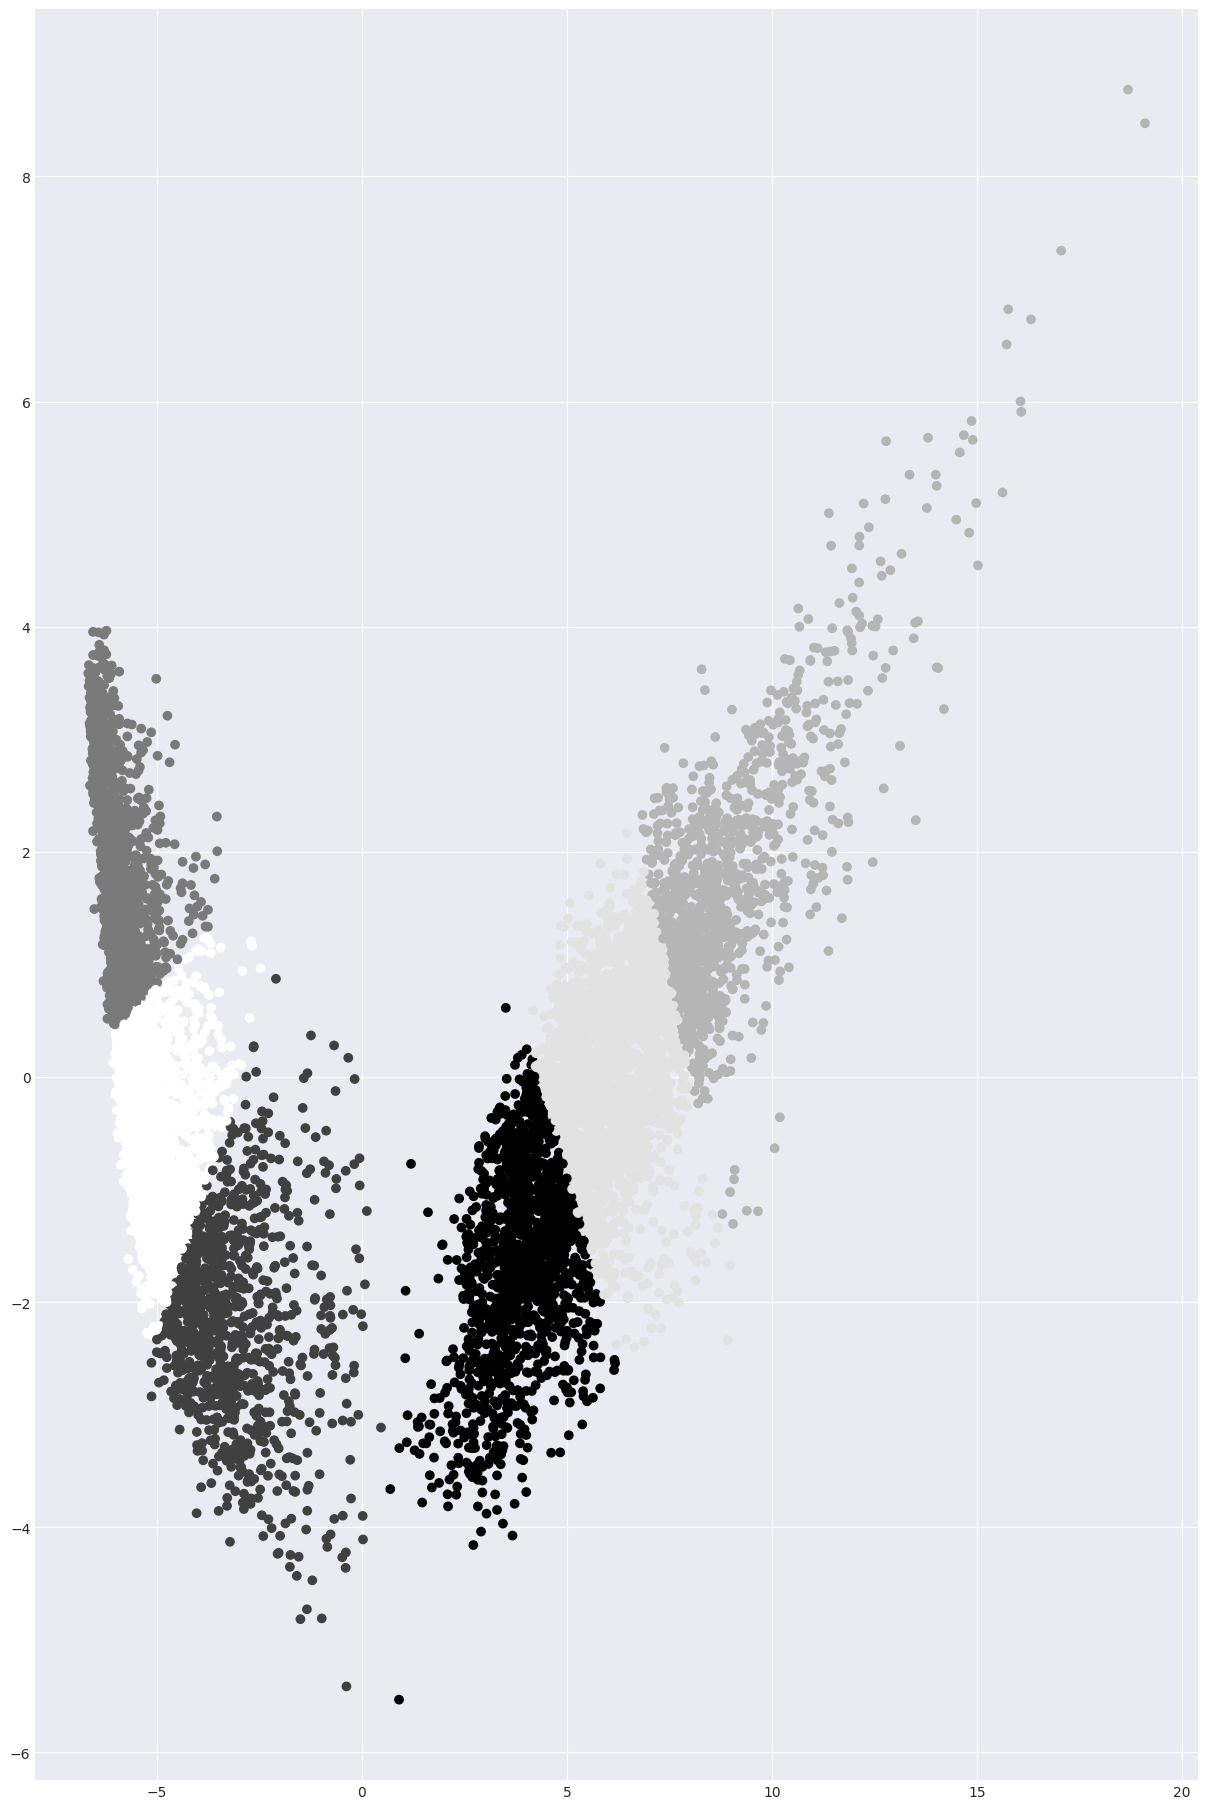

In [85]:
from sklearn.cluster import MiniBatchKMeans

plt.figure(figsize= (15,23))

ms = MiniBatchKMeans(n_clusters=6, random_state=0)
clusters = ms.fit_predict(X_transformed)
plt.scatter(X_transformed[:,0], X_transformed[:,1], c = clusters)

plt.show()  

In [87]:
labels = y

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, ms.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, ms.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, ms.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, ms.labels_))
print("Adjusted mutual info score: %.3f"
      % metrics.adjusted_mutual_info_score(labels, ms.labels_))

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, ms.labels_, sample_size=1000))

Homogeneity: 0.450
Completeness: 0.461
V-measure: 0.456
Adjusted Rand-Index: 0.296
Adjusted mutual info score: 0.455
Silhouette Coefficient: 0.072


Для самой успешной из полученных кластеризаций попробуйте дать интерпретацию кластеров. Опишите характеристики объектов, попавших в каждый кластер. Для этого можете ответить на следующие вопросы:

* похожи ли объекты внутри каждого кластера на определенный тип активности человека?
* в каких кластерах смешано несколько типов активности? С чем, на ваш взгляд, это может быть связано?
* качественная ли получилась кластеризация? На основании чего вы можете сделать такой вывод?

In [ ]:
# по метрикам лучше всего сработал dbscan, хотя гомогенность у него ниже всех остальных. но я смотрю на этот график и понимаю что абсолютно неправильно все сделала, видимо eps и min_samples подобраны неверно